# Imports

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
tf.__version__

'1.15.3'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Download the Flowers Dataset using TF Datasets

In [5]:
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:]'], with_info=True, as_supervised=True)

    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


# Print Information about Dataset 

In [6]:
num_classes = dataset_info.features['label'].num_classes 

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [7]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches

In [8]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(42).map(format_image).cache().batch(BATCH_SIZE).repeat().prefetch(1) 
validation_batches = validation_set.map(format_image).cache().batch(BATCH_SIZE).repeat().prefetch(1)

# Create a Feature Extractor

In [9]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

# Freeze the Pre-Trained Model

In [10]:
feature_extractor.trainable = False

# Attach a classification head

In [11]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 658,437
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [12]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("flowers_weights.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, amsgrad=True)

model.compile(optimizer=opt, loss=loss, metrics=['acc'])

In [13]:
history = model.fit(train_batches,
                    epochs=500,
                    steps_per_epoch=num_training_examples//32,
                    validation_data=validation_batches,
                    validation_steps=num_validation_examples//32,
                    verbose=1,
                    callbacks=[model_checkpoint, early_stopping])

Train for 80 steps, validate for 34 steps
Epoch 1/500
80/80 [==============================] - 8s 97ms/step - loss: 1.4969 - acc: 0.3629 - val_loss: 1.2407 - val_acc: 0.5634
Epoch 2/500
80/80 [==============================] - 3s 43ms/step - loss: 1.1780 - acc: 0.5522 - val_loss: 1.0114 - val_acc: 0.6994
Epoch 3/500
80/80 [==============================] - 3s 41ms/step - loss: 0.9838 - acc: 0.6516 - val_loss: 0.8609 - val_acc: 0.7546
Epoch 4/500
80/80 [==============================] - 3s 39ms/step - loss: 0.8516 - acc: 0.7249 - val_loss: 0.7572 - val_acc: 0.7840
Epoch 5/500
80/80 [==============================] - 3s 40ms/step - loss: 0.7526 - acc: 0.7678 - val_loss: 0.6814 - val_acc: 0.8042
Epoch 6/500
80/80 [==============================] - 3s 40ms/step - loss: 0.6759 - acc: 0.7864 - val_loss: 0.6248 - val_acc: 0.8153
Epoch 7/500
80/80 [==============================] - 3s 40ms/step - loss: 0.6249 - acc: 0.7911 - val_loss: 0.5796 - val_acc: 0.8235
Epoch 8/500
80/80 [===============

80/80 [==============================] - 3s 38ms/step - loss: 0.1585 - acc: 0.9590 - val_loss: 0.2783 - val_acc: 0.9007
Epoch 60/500
80/80 [==============================] - 3s 39ms/step - loss: 0.1552 - acc: 0.9637 - val_loss: 0.2777 - val_acc: 0.9017
Epoch 61/500
80/80 [==============================] - 3s 39ms/step - loss: 0.1574 - acc: 0.9606 - val_loss: 0.2769 - val_acc: 0.9017
Epoch 62/500
80/80 [==============================] - 3s 40ms/step - loss: 0.1531 - acc: 0.9602 - val_loss: 0.2761 - val_acc: 0.9007
Epoch 63/500
80/80 [==============================] - 3s 39ms/step - loss: 0.1502 - acc: 0.9641 - val_loss: 0.2754 - val_acc: 0.9035
Epoch 64/500
80/80 [==============================] - 3s 39ms/step - loss: 0.1531 - acc: 0.9606 - val_loss: 0.2750 - val_acc: 0.9026
Epoch 65/500
80/80 [==============================] - 3s 40ms/step - loss: 0.1433 - acc: 0.9693 - val_loss: 0.2743 - val_acc: 0.9035
Epoch 66/500
80/80 [==============================] - 3s 37ms/step - loss: 0.1456 

80/80 [==============================] - 3s 39ms/step - loss: 0.0808 - acc: 0.9850 - val_loss: 0.2586 - val_acc: 0.9072
Epoch 121/500
80/80 [==============================] - 3s 40ms/step - loss: 0.0789 - acc: 0.9870 - val_loss: 0.2586 - val_acc: 0.9072
Epoch 122/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0798 - acc: 0.9846 - val_loss: 0.2586 - val_acc: 0.9072
Epoch 123/500
80/80 [==============================] - 3s 40ms/step - loss: 0.0784 - acc: 0.9882 - val_loss: 0.2584 - val_acc: 0.9072
Epoch 124/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0768 - acc: 0.9890 - val_loss: 0.2586 - val_acc: 0.9090
Epoch 125/500
80/80 [==============================] - 3s 39ms/step - loss: 0.0754 - acc: 0.9898 - val_loss: 0.2578 - val_acc: 0.9090
Epoch 126/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0766 - acc: 0.9858 - val_loss: 0.2578 - val_acc: 0.9090
Epoch 127/500
80/80 [==============================] - 3s 37ms/step - loss: 

80/80 [==============================] - 3s 37ms/step - loss: 0.0513 - acc: 0.9937 - val_loss: 0.2563 - val_acc: 0.9090
Epoch 182/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0496 - acc: 0.9929 - val_loss: 0.2561 - val_acc: 0.9099
Epoch 183/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0494 - acc: 0.9953 - val_loss: 0.2559 - val_acc: 0.9108
Epoch 184/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0490 - acc: 0.9957 - val_loss: 0.2562 - val_acc: 0.9118
Epoch 185/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0495 - acc: 0.9941 - val_loss: 0.2562 - val_acc: 0.9081
Epoch 186/500
80/80 [==============================] - 3s 37ms/step - loss: 0.0499 - acc: 0.9945 - val_loss: 0.2560 - val_acc: 0.9108
Epoch 187/500
80/80 [==============================] - 3s 38ms/step - loss: 0.0511 - acc: 0.9929 - val_loss: 0.2558 - val_acc: 0.9081


#  Plot Training and Validation Graphs

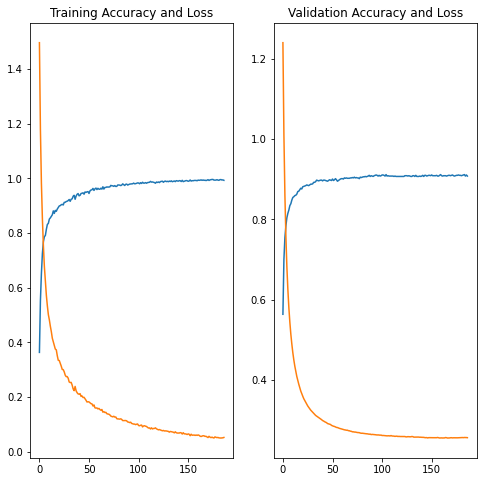

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(loss, label='Training Loss')
plt.title('Training Accuracy and Loss')

plt.subplot(1, 2, 2)
plt.plot(val_acc, label="Validation Accuracy")
plt.plot(val_loss, label="Validation Loss")
plt.title('Validation Accuracy and Loss')
plt.show()

# Check Predictions

In [17]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


# Create an Image Batch and Make Predictions

In [18]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

# Print True Labels and Predicted Indices

In [19]:
print(predicted_class_names)

['roses' 'roses' 'daisy' 'tulips' 'sunflowers' 'sunflowers' 'sunflowers'
 'sunflowers' 'daisy' 'dandelion' 'sunflowers' 'sunflowers' 'tulips'
 'dandelion' 'dandelion' 'sunflowers' 'daisy' 'tulips' 'tulips' 'roses'
 'tulips' 'roses' 'sunflowers' 'tulips' 'dandelion' 'daisy' 'tulips'
 'daisy' 'roses' 'tulips' 'dandelion' 'roses']


# Plot Model Predictions

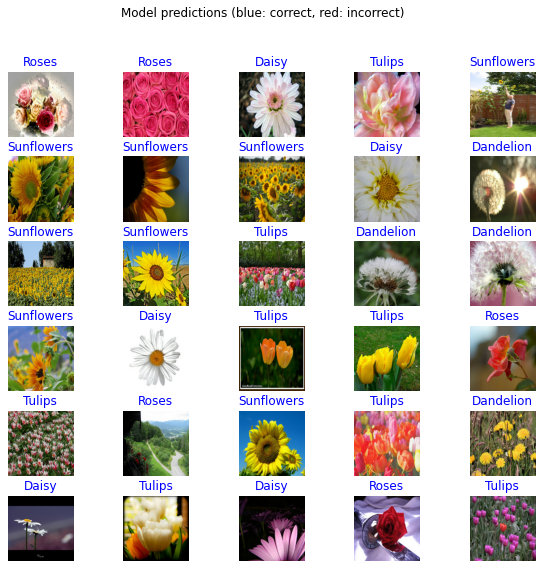

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")